In [ ]:
from training_rl.offline_rl.custom_envs.custom_envs_registration import register_grid_envs
import warnings
from training_rl.offline_rl.load_env_variables import load_env_variables
from training_rl.offline_rl.scripts.visualizations.utils import snapshot_env
from training_rl.offline_rl.custom_envs.utils import Grid2DInitialConfig, InitialConfigCustom2DGridEnvWrapper
from training_rl.offline_rl.custom_envs.custom_2d_grid_env.obstacles_2D_grid_register import ObstacleTypes
from training_rl.offline_rl.custom_envs.custom_envs_registration import CustomEnv
from training_rl.offline_rl.behavior_policies.behavior_policy_registry import BehaviorPolicyType
from training_rl.offline_rl.generate_custom_minari_datasets.generate_minari_dataset_grid_envs import \
    create_combined_minari_dataset
from training_rl.offline_rl.custom_envs.custom_envs_registration import RenderMode
from training_rl.offline_rl.offline_policies.offpolicy_rendering import offpolicy_rendering
from training_rl.offline_rl.scripts.visualizations.utils import get_state_action_data_and_policy_grid_distributions
from training_rl.offline_rl.utils import load_buffer_minari, state_action_histogram
from training_rl.offline_rl.offline_trainings.policy_config_data_class import TrainedPolicyConfig
from training_rl.offline_rl.offline_policies.policy_registry import PolicyName
from training_rl.offline_rl.offline_trainings.offline_training import offline_training
import torch
from training_rl.offline_rl.offline_trainings.policy_config_data_class import get_trained_policy_path
import os
from training_rl.offline_rl.offline_trainings.restore_policy_model import restore_trained_offline_policy
from training_rl.offline_rl.utils import compare_state_action_histograms
import gymnasium as gym


load_env_variables()
warnings.filterwarnings("ignore")
register_grid_envs()

### EXERCISE:

In this exercise we have two datasets that tries to bring the agent from (3,0) to (7,7) . One policy is suboptimal and the other is optimal.

I  - **Suboptimal expert policy**:  collect ~ 8000 steps

II - **expert policy**: collect ~ 300 steps

(This could be a realistic situation where you could have only a few human expert data available and the rest of the data is collected through a far from optimal policy.)

**We will use in this example as off-policy RL policy, the Deep Q-Network (DQN) algorithm,** that we introduced in the online RL section. As the DQN agent cannot interact with the environment we will feed the collected data through a ReplyBuffer, similarly as we did before in the imitation learning example.


Exercise: (Give a look to the imitation learning exercise)

1 - **We will use the 8x8 grid environment with a vertical obstacle : ObstacleTypes.dqn_obstacle_8x8**.

2 - **The policies: behavior_8x8_eps_greedy_4_0_to_7_7 and behavior_8x8_deterministic_4_0_to_7_7)**

3 - **For the dataset collection give a look to the solution**, specifically to the points:

- Configure the two datasets
- Create Minari combined datasets 

as we will fuse the two datasets coming from different policies into a single one (as you should do in a real problem)

4 - **Do the training using as policy BehaviorPolicyType.dqn to have a felling of how good (or how bad) is an offpolicy algorithm to deal with collected data.**

### SOLUTION:

### Environment

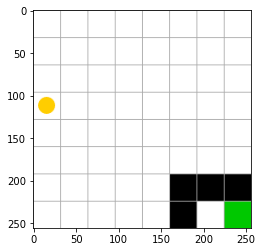

In [2]:
ENV_NAME = CustomEnv.Grid_2D_8x8_discrete

# Grid configuration
OBSTACLE = ObstacleTypes.dqn_obstacle_8x8
INITIAL_STATE = (3, 0)
FINAL_STATE = (7, 7)

env_2D_grid_initial_config = Grid2DInitialConfig(
    obstacles=OBSTACLE,
    initial_state=INITIAL_STATE,
    target_state=FINAL_STATE,
)

env = InitialConfigCustom2DGridEnvWrapper(gym.make(ENV_NAME, render_mode=RenderMode.RGB_ARRAY_LIST), env_config=env_2D_grid_initial_config)
snapshot_env(env)

### Configure the two datasets

In [3]:
BEHAVIOR_POLICY_I = BehaviorPolicyType.behavior_8x8_eps_greedy_4_0_to_7_7
DATA_SET_IDENTIFIER_I = "_suboptimal"
NUM_STEPS_I = 8000

BEHAVIOR_POLICY_II = BehaviorPolicyType.behavior_8x8_deterministic_4_0_to_7_7
DATA_SET_IDENTIFIER_II = "_expert"
NUM_STEPS_II = 300


### Create Minari combined datasets 
( give a look to **create_combined_minari_dataset(...)** ) 

In [4]:
config_combined_data = create_combined_minari_dataset(
        env_name=ENV_NAME,
        dataset_names = (DATA_SET_IDENTIFIER_I, DATA_SET_IDENTIFIER_II),
        num_collected_points = (NUM_STEPS_I, NUM_STEPS_II),
        behavior_policy_names = (BEHAVIOR_POLICY_I, BEHAVIOR_POLICY_II),
        combined_dataset_identifier = "combined_data_sets_random_walk",
        env_2d_grid_initial_config = env_2D_grid_initial_config,
)

Dataset Grid_2D_8x8_discrete-data_dqn_obstacle_8x8_start_3_0_target_7_7_suboptimal-V0 deleted!
Dataset Grid_2D_8x8_discrete-data_dqn_obstacle_8x8_start_3_0_target_7_7_expert-V0 deleted!
Dataset Grid_2D_8x8_discrete-combined_data_sets_random_walk-V0 deleted!
Number of episodes in dataset I:134, in dataset I:5 and  in the combined dataset: 139


### Rendering behavioral policy

In [ ]:
# Suboptimal policy
offpolicy_rendering(
    env_or_env_name=ENV_NAME,
    render_mode=RenderMode.RGB_ARRAY_LIST,
    behavior_policy_name=BEHAVIOR_POLICY_I,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=100,
)

In [ ]:
# Expert policy
offpolicy_rendering(
    env_or_env_name=ENV_NAME,
    render_mode=RenderMode.RGB_ARRAY_LIST,
    behavior_policy_name=BEHAVIOR_POLICY_II,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=1000,
)

### Let's give a look to the state-action distribution

Dataset /home/ivan/Documents/GIT_PROJECTS/Tianshou/tianshou/examples/offline_RL_workshop/data/offline_data/Grid_2D_8x8_discrete-combined_data_sets_random_walk-V0 downloaded. number of episodes: 139


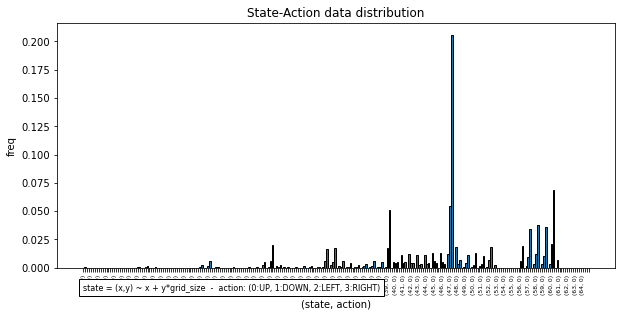

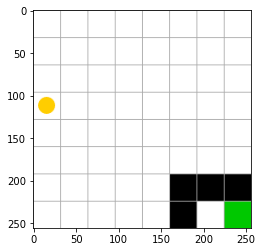

In [5]:
#Create Buffers with minari datasets
name_combined_dataset = config_combined_data.data_set_name

buffer_data = load_buffer_minari(name_combined_dataset)

# Compute state-action data distribution
state_action_count_data, _ = get_state_action_data_and_policy_grid_distributions(buffer_data, env)
state_action_histogram(state_action_count_data, title="State-Action data distribution", inset_pos_xy=(-0.1, -0.02))

snapshot_env(env)

### Choose the policy to train

In [23]:
POLICY_NAME = PolicyName.dqn

NAME_EXPERT_DATA = name_combined_dataset
# TrainedPolicyConfig is a handy object that will help us to deal with the policy configuration data.
offline_policy_config = TrainedPolicyConfig(
    name_expert_data=NAME_EXPERT_DATA,
    policy_name=POLICY_NAME,
    render_mode=RenderMode.RGB_ARRAY_LIST,
    device="cpu"
)


### Training

In [ ]:
# Run the training

NUM_EPOCHS = 50
BATCH_SIZE = 256
UPDATE_PER_EPOCH = 100

# After every epoch we will collect some test statistics from the policy from NUMBER_TEST_ENVS independent envs.
NUMBER_TEST_ENVS = 1
EXPLORATION_NOISE = True
SEED = None #1626


offline_training(
    offline_policy_config=offline_policy_config,
    num_epochs = NUM_EPOCHS,
    number_test_envs=NUMBER_TEST_ENVS,
    update_per_epoch=UPDATE_PER_EPOCH,
    restore_training=False,
)

### Restore policy

In [26]:
POLICY_FILE = "policy_final.pth"

# restore a policy with the same configuration as the one we trained.
policy = restore_trained_offline_policy(offline_policy_config)
# load the weights
name_expert_data = offline_policy_config.name_expert_data
log_name = os.path.join(name_expert_data, POLICY_NAME)
log_path = get_trained_policy_path(log_name)
policy.load_state_dict(torch.load(os.path.join(log_path, POLICY_FILE), map_location="cpu"))


observation/action shapes (64, 4)


<All keys matched successfully>

### Let's visualize the policy

In [27]:
#env_2D_grid_initial_config.obstacles = OBSTACLE.obst_free_8x8
#env = InitialConfigCustom2DGridEnvWrapper(gym.make(ENV_NAME, render_mode=RenderMode.RGB_ARRAY_LIST), env_config=env_2D_grid_initial_config)

offpolicy_rendering(
    env_or_env_name=env,
    render_mode=RenderMode.RGB_ARRAY_LIST,
    policy_model=policy,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=1000,
    imitation_policy_sampling=False
)

QObject::moveToThread: Current thread (0x5573f5eb9540) is not the object's thread (0x5573f55d27e0).
Cannot move to target thread (0x5573f5eb9540)

QObject::moveToThread: Current thread (0x5573f5eb9540) is not the object's thread (0x5573f55d27e0).
Cannot move to target thread (0x5573f5eb9540)

QObject::moveToThread: Current thread (0x5573f5eb9540) is not the object's thread (0x5573f55d27e0).
Cannot move to target thread (0x5573f5eb9540)

QObject::moveToThread: Current thread (0x5573f5eb9540) is not the object's thread (0x5573f55d27e0).
Cannot move to target thread (0x5573f5eb9540)

QObject::moveToThread: Current thread (0x5573f5eb9540) is not the object's thread (0x5573f55d27e0).
Cannot move to target thread (0x5573f5eb9540)

QObject::moveToThread: Current thread (0x5573f5eb9540) is not the object's thread (0x5573f55d27e0).
Cannot move to target thread (0x5573f5eb9540)

QObject::moveToThread: Current thread (0x5573f5eb9540) is not the object's thread (0x5573f55d27e0).
Cannot move to tar

InterruptedError: You quit ('q') the animation.

### State-action distribution policy distribution

In [25]:
NUM_EPISODES = 100 # as more episodes the better

# compute statistics
state_action_count_data, state_action_count_policy = \
    get_state_action_data_and_policy_grid_distributions(
    buffer_data,
    env,
    policy,
    num_episodes=NUM_EPISODES,
    logits_sampling=True,
)

# plots
state_action_histogram(state_action_count_data)
state_action_histogram(state_action_count_policy)
compare_state_action_histograms(state_action_count_data, state_action_count_policy)
snapshot_env(env)

Processing:   2%|█                                                  | 2/100 [00:02<02:14,  1.37s/it]


KeyboardInterrupt: 

### Exercise 2:

#### 1 - Train again the DQN but now with random data (i.e. suboptimal random policy  and increase the expert data too, 
#### expert data ~ 30000).

Is the policy better? Why?

Remove the walls and see what happens.

In [ ]:
env_2D_grid_initial_config.obstacles = ObstacleTypes.obst_free_8x8
env = InitialConfigCustom2DGridEnvWrapper(gym.make(ENV_NAME, render_mode=RenderMode.RGB_ARRAY_LIST), env_config=env_2D_grid_initial_config)

offpolicy_rendering(
    env_or_env_name=env,
    render_mode=RenderMode.RGB_ARRAY_LIST,
    policy_model=policy,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=1000,
    imitation_policy_sampling=False
)

#### 2 - Try now with  with the original problem and try one of the offline RL algorithms that we will introduce later:  BCQ.

What happens now?

BCQ as all the offline RL algorithms has tuning parameters to control o.o.d data. They are typically tune to some empirical values that solve a huge range of tasks but in general these are important parameters you will need to tune in your experiments.